In [3]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings
import pandas as pd

np.random.seed(42)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [7]:
import csv
def write_synthetic():
    with open('Synthetic.csv', 'w') as csvfile:
        fieldnames = ['Marks', 'Attendance','Salary','Gender','Kids']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        m = 10000
        noise = 5000
        # Salary = (3*Marks + 2*Attendance)*1000
        for i in range(m):
            # 1st column is marks 
            # 2nd is attendance
            # 3rd is salary 
            # 4th is gender
            marks = 20 + np.random.rand(1)*80
            att = 50 + np.random.rand(1)*50
            salary = (3*marks + 2*att)*100
            kids = 2*(np.random.rand(1)+1.5)*(salary+noise)/50000
            gender = ''
            if salary > 33000 : 
                gender = "Girl"
            else:
                gender = "Boy"
            salary += noise*np.random.rand(1) - noise/2 
            writer.writerow({'Marks': marks[0], 'Attendance': att[0], 'Salary' :salary[0],'Gender':gender,'Kids' : int(kids[0])})
write_synthetic()

In [8]:
data = pd.read_csv("./Synthetic.csv")
data_copy = data.copy(deep="True")
#data.head()

In [10]:
data["Kids"].value_counts()
#data.info()
#data.describe()

2    4355
3    3753
4    1150
1     707
5      35
Name: Kids, dtype: int64

In [86]:
#data.hist(bins=100, figsize=(12,6))
#plt.show()

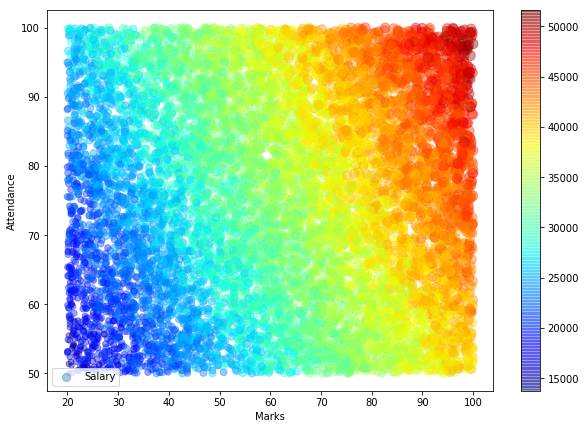

In [245]:
data.plot(kind="scatter", x="Marks", y="Attendance", alpha=0.4,
    s=data["Salary"]/500, label="Salary", figsize=(10,7),
    c=data["Salary"], cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

In [246]:
corr_matrix = data.corr()
corr_matrix["Salary"].sort_values(ascending=False)

Salary        1.000000
Marks         0.904738
Kids          0.737660
Attendance    0.381312
Name: Salary, dtype: float64

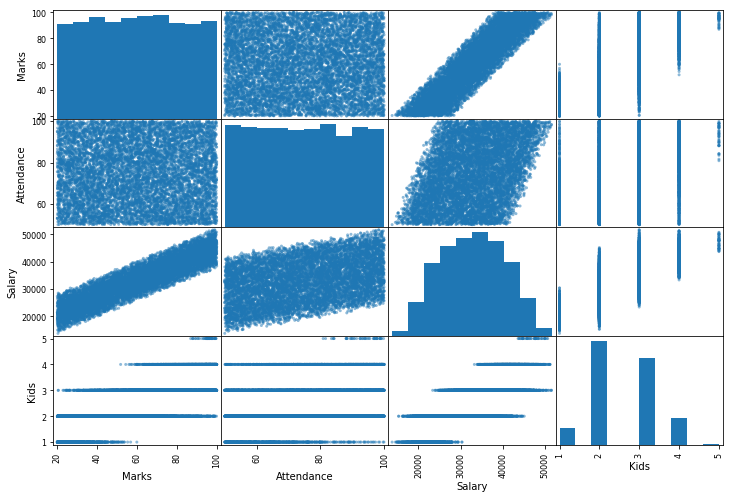

In [247]:
from pandas.plotting import scatter_matrix
attributes = ["Marks", "Attendance", "Salary","Kids"]
scatter_matrix(data[attributes], figsize=(12, 8))
plt.show()

Preparing the data for ML algorithms............

In [90]:
data.dropna(subset=["Marks"])               # option 1
#data.drop("total_bedrooms", axis=1)        # option 2
median = data["Marks"].median()
data["Marks"].fillna(median, inplace=True)  # option 3

In [91]:
data_cat = data['Gender']

In [92]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [93]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
data_cat_reshaped = data_cat.values.reshape(-1, 1)
data_cat_1hot = cat_encoder.fit_transform(data_cat_reshaped)

In [94]:
cat_encoder.categories_

[array(['Boy', 'Girl'], dtype=object)]

Custom transformer to add extra attributes

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin

salary_ix, kid_ix = 2, 3

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        salary_per_kid = np.zeros((len(X),1))
        for i in range(len(X)):
            salary_per_kid[i,0] = X[i, salary_ix] / X[i, kid_ix]
        return np.c_[X, salary_per_kid]

#attr_adder = CombinedAttributesAdder()
#data_extra_attribs = attr_adder.transform(data.values)

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,Imputer

In [97]:
data_num = data.drop('Gender', axis=1)
#data_num.head()

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [99]:
num_attribs = list(data_num)
cat_attribs = ["Gender"]
print(DataFrameSelector(list(data_num)))
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

DataFrameSelector(attribute_names=['Marks', 'Attendance', 'Salary', 'Kids'])


In [100]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [102]:
data_prepared = full_pipeline.fit_transform(data)
#data_prepared

In [103]:
#data_prepared.shape

In [104]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_prepared, test_size=0.2, random_state=42)

In [109]:
print(len(train_set), "train +", len(test_set), "test")

8000 train + 2000 test


In [203]:
def name_func(X):
    Y = []
    for i in range(len(X)):
        str = ''
        # [0 1] -> Girl [1 0] -> Boy
        if int(X[i][5]) == 0 and int(X[i][6]) == 1:
            str = "Girl"
        elif int(X[i][5]) == 1 and int(X[i][6]) == 0:
            str = "Boy"
        Y.append(str)
    return np.array(Y).reshape(-1,1)

In [205]:
from sklearn.linear_model import LinearRegression
X = data_prepared[:,0:5]
Y = data_prepared[:,5:7]
Yname = name_func(data_prepared)
Xtr = train_set[:,0:5]
Ytr = train_set[:,5:7]
Ytrname = name_func(train_set)
Xte = test_set[:,0:5]
Yte = test_set[:,5:7]
Ytename = name_func(test_set)
lin_reg = LinearRegression()
lin_reg.fit(Xtr, Ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [186]:
from sklearn.metrics import mean_squared_error

data_predictions = lin_reg.predict(Xte)
lin_mse = mean_squared_error(Yte, data_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.2735396089850114

In [113]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(Yte, data_predictions)
lin_mae

0.23324250457251905

In [114]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(Xtr, Ytr)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [115]:
data_predictions = tree_reg.predict(Xte)
tree_mse = mean_squared_error(Yte, data_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.1284523257866513

Fine tune your model

In [119]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X, Y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [120]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [0.11401754 0.12247449 0.13784049 0.13038405 0.11401754 0.1
 0.1183216  0.15491933 0.12247449 0.12247449]
Mean: 0.12369240115725486
Standard deviation: 0.014148847866619355


In [121]:
lin_scores = cross_val_score(lin_reg, X, Y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.27247064 0.27668027 0.26992893 0.27249078 0.27152381 0.27930668
 0.26988801 0.27463255 0.27011744 0.27559355]
Mean: 0.27326326505655524
Standard deviation: 0.0030358023786045984


In [123]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(Xtr, Ytr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [124]:
data_predictions = forest_reg.predict(Xte)
forest_mse = mean_squared_error(Yte, data_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.09452512893405642

In [125]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, X, Y, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.08882567 0.09       0.08734987 0.09038805 0.08024961 0.09407444
 0.10440307 0.12016655 0.08809086 0.09864076]
Mean: 0.09421888854053487
Standard deviation: 0.010667757130074932


In [208]:
from sklearn.svm import SVC

svm_reg = SVC(kernel="linear")
svm_reg.fit(Xtr, Ytrname)
data_predictions = svm_reg.predict(Xte)
print(data_predictions)

['Boy' 'Boy' 'Girl' ... 'Boy' 'Boy' 'Girl']


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [146]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30]},{'bootstrap': [False], 'n_estimators': [3, 10]}]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (3+2)*5=25 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [147]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'n_estimators': 30}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


In [148]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.10381607668264953 {'n_estimators': 3}
0.09453041838477176 {'n_estimators': 10}
0.09246320589534221 {'n_estimators': 30}
0.11455226851626389 {'bootstrap': False, 'n_estimators': 3}
0.11353853971229329 {'bootstrap': False, 'n_estimators': 10}


In [150]:
#pd.DataFrame(grid_search.cv_results_)

In [153]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators': randint(low=1, high=200)}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5d644f4550>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [154]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.0901082810254417 {'n_estimators': 103}
0.0900960735500488 {'n_estimators': 180}
0.09023068802204653 {'n_estimators': 93}
0.09498771850437648 {'n_estimators': 15}
0.09008419892701955 {'n_estimators': 107}
0.09099512010386081 {'n_estimators': 72}
0.09011383548252214 {'n_estimators': 189}
0.09357233732746642 {'n_estimators': 21}
0.0901082810254417 {'n_estimators': 103}
0.09008979813513907 {'n_estimators': 122}


In [155]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.29507183e-02, 5.99514037e-02, 8.62526350e-01, 2.86998914e-04,
       4.28452880e-03])

In [209]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]
# predicting salary from marks and attendance
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(X[:,0:2],X[:,3])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   8.5s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   8.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  10.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  10.4s
[CV] C=30.0, ke

KeyboardInterrupt: 

In [211]:
#negative_mse = grid_search.best_score_
#rmse = np.sqrt(-negative_mse)
#rmse

In [213]:
#grid_search.best_params_

In [215]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
#rnd_search.fit(X[:,0:2],X[:,3])

In [217]:
#negative_mse = rnd_search.best_score_
#rmse = np.sqrt(-negative_mse)
#rmse

In [218]:
#rnd_search.best_params_

Chapter: Classification

In [223]:
shuffle_index = np.random.permutation(len(Xtr))
Xtr, Ytr = Xtr[shuffle_index], Ytr[shuffle_index]

In [228]:
Ytr_girl_bool = (Ytrname == 'Girl')
Yte_girl_bool = (Ytename == 'Girl')

In [229]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(Xtr, Ytr_girl_bool)

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [230]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, Xtr, Ytr_girl_bool, cv=3, scoring="accuracy")

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.45181852, 0.5984252 , 0.51425356])

In [232]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(Xtr, Ytr_girl_bool):
    clone_clf = clone(sgd_clf)
    X_train_folds = Xtr[train_index]
    y_train_folds = (Ytr_girl_bool[train_index])
    X_test_fold = Xtr[test_index]
    y_test_fold = (Ytr_girl_bool[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

[0.62954631 0.62954631 0.37045369 ... 0.37045369 0.62954631 0.62954631]
[0.62954631 0.62954631 0.62954631 ... 0.62954631 0.37045369 0.62954631]
[0.37021755 0.62978245 0.62978245 ... 0.62978245 0.62978245 0.62978245]


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [234]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

Y_tr_pred = cross_val_predict(sgd_clf, Xtr, Ytr_girl_bool, cv=3)
confusion_matrix(Ytr_girl_bool, Y_tr_pred)

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1149, 1814],
       [2014, 3023]])

In [237]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(Ytr_girl_bool, Y_tr_pred)

0.6249741575356627

In [238]:
recall_score(Ytr_girl_bool, Y_tr_pred)

0.6001588246972405

In [239]:
f1_score(Ytr_girl_bool, Y_tr_pred)

0.6123151711565729

In [241]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(Ytr_girl_bool, Y_tr_pred)

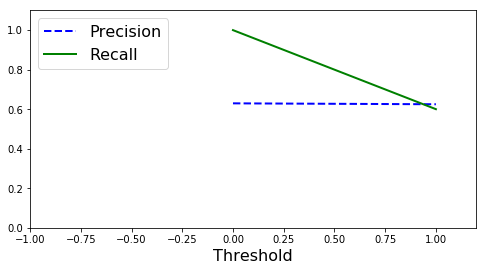

In [257]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1.1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-1, 1.2])
plt.show()

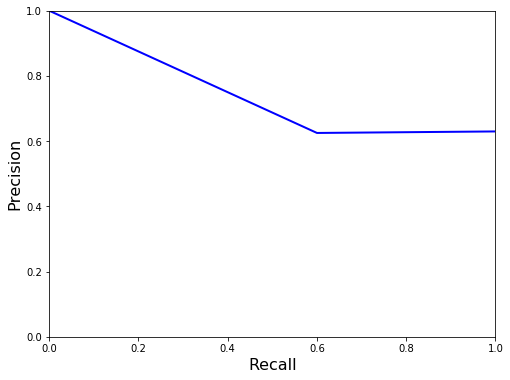

In [260]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

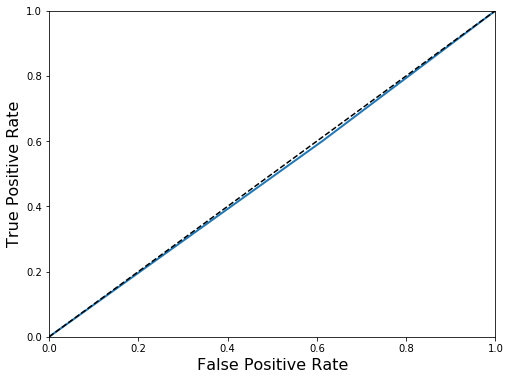

In [262]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Ytr_girl_bool, Y_tr_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [263]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Ytr_girl_bool, Y_tr_pred)

0.4939707387070408

In [264]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, Xtr, Ytr_girl_bool, cv=3,method="predict_proba")

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [265]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Ytr_girl_bool,y_scores_forest)

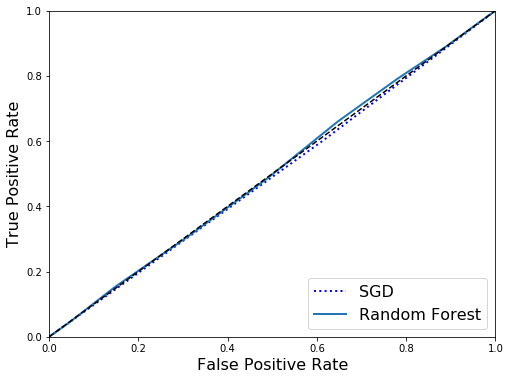

In [268]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [269]:
roc_auc_score(Ytr_girl_bool, y_scores_forest)

0.5027574216072744

In [270]:
y_train_pred_forest = cross_val_predict(forest_clf, Xtr, Ytr_girl_bool, cv=3)
precision_score(Ytr_girl_bool, y_train_pred_forest)

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:753: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:753: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:753: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


0.6343511450381679

In [271]:
recall_score(Ytr_girl_bool, y_train_pred_forest)

0.6599166170339488

Multiclass classification

In [296]:
sgd_clf.fit(Xtr, Ytrname)
sgd_clf.predict([Xtr[9]])

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['Girl'], dtype='<U4')

In [299]:
some_digit_scores = sgd_clf.decision_function([Xtr[10]])
some_digit_scores

array([-1.04303095])

In [300]:
sgd_clf.classes_

array(['Boy', 'Girl'], dtype='<U4')

In [301]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(Xtr, Ytrname)
ovo_clf.predict([Xtr[9]])

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['Girl'], dtype='<U4')

In [302]:
len(ovo_clf.estimators_)

1

In [303]:
forest_clf.fit(Xtr, Ytrname)
forest_clf.predict([Xtr[9]])

/home/arav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


array(['Girl'], dtype='<U4')

In [309]:
forest_clf.predict_proba([Xtr[9]])

array([[0.3, 0.7]])

In [310]:
cross_val_score(sgd_clf, Xtr, Ytrname, cv=3, scoring="accuracy")

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.45181852, 0.5984252 , 0.51425356])

In [311]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xtrainscaled = scaler.fit_transform(Xtr.astype(np.float64))
cross_val_score(sgd_clf, Xtrainscaled, Ytrname, cv=3, scoring="accuracy")

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.45106862, 0.57142857, 0.49737434])

In [312]:
y_train_pred = cross_val_predict(sgd_clf, Xtrainscaled, Ytrname, cv=3)
conf_mx = confusion_matrix(Ytrname, y_train_pred)
conf_mx

/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1230, 1733],
       [2214, 2823]])

In [313]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(Xtr, Ytrname)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=3, weights=uniform, score=0.5503439649781113, total=   0.0s
[CV]  n_neighbors=3, weights=uniform, score=0.5384134915677702, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] n_neighbors=3, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=3, weights=uniform, score=0.5665209244222361, total=   0.1s
[CV] ..... n_neighbors=3, weights=uniform, score=0.5475, total=   0.1s
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=3, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=3, weights=uniform, score=0.5472170106316447, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.5646470955652717, total=   0.0s
[CV]  n_neighbors=3, weights=distance, score=0.5415365396627108, total=   0.0s


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] n_neighbors=4, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=distance, score=0.55, total=   0.0s


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] n_neighbors=4, weights=uniform ..................................
[CV] n_neighbors=4, weights=uniform ..................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=3, weights=distance, score=0.5459662288930581, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=4, weights=uniform, score=0.5209244222361025, total=   0.0s


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ....... n_neighbors=4, weights=uniform, score=0.52, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] n_neighbors=4, weights=uniform ..................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=4, weights=uniform, score=0.50093808630394, total=   0.1s
[CV] n_neighbors=4, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.5522201375859912, total=   0.0s


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] n_neighbors=4, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=4, weights=uniform, score=0.5190744215134458, total=   0.0s
[CV] n_neighbors=4, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=4, weights=uniform, score=0.5021861336664585, total=   0.1s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=4, weights=distance, score=0.532792004996877, total=   0.0s


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] n_neighbors=4, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=4, weights=distance, score=0.5552779512804498, total=   0.1s
[CV] n_neighbors=5, weights=uniform ..................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=4, weights=distance, score=0.5590994371482176, total=   0.0s
[CV] n_neighbors=4, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... n_neighbors=4, weights=distance, score=0.56375, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.5840099937539038, total=   0.0s


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] n_neighbors=5, weights=uniform ..................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... n_neighbors=5, weights=uniform, score=0.566875, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=4, weights=distance, score=0.5522201375859912, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=5, weights=uniform, score=0.5540963101938712, total=   0.0s
[CV]  n_neighbors=5, weights=uniform, score=0.5534041224234854, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV] n_neighbors=5, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=5, weights=uniform, score=0.5584740462789243, total=   0.0s
[CV]  n_neighbors=5, weights=distance, score=0.5534041224234854, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=5, weights=distance, score=0.5547217010631644, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................


/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_neighbors=5, weights=distance, score=0.5740162398500936, total=   0.0s
[CV] .. n_neighbors=5, weights=distance, score=0.574375, total=   0.0s
[CV]  n_neighbors=5, weights=distance, score=0.5528455284552846, total=   0.0s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished
/home/arav/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [314]:
grid_search.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

In [315]:
grid_search.best_score_

0.563375

In [316]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(Xte)
accuracy_score(Ytename, y_pred)

0.5505

Linear models